# Step 5: Training plates model

## Imports

In [22]:
import json
import os
from argparse import Namespace

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

from src.local_utils import training_utils
from src.local_utils.constants import (
    MODEL_CONFIG_FILE,
    RU_PLATES_IMAGES_PATH,
    RU_PLATES_ANNOTATIONS_PATH,
    PLATES_TRAINING_SET_FILE,
    PLATES_VALIDATION_SET_FILE,
    RU_PLATES_LABELS_FILE,
    PLATES_HISTORY_FILE,
    PLATES_BEST_MODEL_FILE,
    OUTPUT_PATH,
)
from src.local_utils.history import history2csv, csv2history

## Model & Dataset Configuration

In [23]:
args = Namespace()
args.config = MODEL_CONFIG_FILE
args.images_dir = RU_PLATES_IMAGES_PATH
args.labels_dir = RU_PLATES_ANNOTATIONS_PATH

## Training Configuration
### Const params

In [24]:
args.training_split = PLATES_TRAINING_SET_FILE
args.validation_split = PLATES_VALIDATION_SET_FILE
args.label_maps = RU_PLATES_LABELS_FILE
args.output_dir = OUTPUT_PATH
args.checkpoint = None

### Changable params

In [36]:
args.learning_rate = 0.001
args.epochs = 1000
args.batch_size = 16
args.shuffle = True
args.augment = False

## Preparation

Checking if output dir is existing.

In [26]:
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

Loading config.

In [27]:
with open(args.config, mode='r') as config_file:
    config = json.load(config_file)

model_config = config['model']
training_config = config['training']

In [28]:
training_data_generator,\
num_training_samples,\
validation_data_generator,\
num_validation_samples = training_utils.get_data_generator(config, args)

Creating data generator for ssd_mobilenetv2
	Training data generator created
	Training set size: 73
	Validation data generator created
	Validation set size: 18

	Done


In [29]:
model = training_utils.get_model(config, args)
loss = training_utils.get_loss(config)
optimizer = training_utils.get_optimizer(args)
model.compile(optimizer=optimizer, loss=loss.compute, metrics='accuracy')

Loading weights if weights file is existing.

In [37]:
if os.path.exists(PLATES_BEST_MODEL_FILE):
    model.load_weights(PLATES_BEST_MODEL_FILE)

## Model summary

In [31]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 301, 301, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 16) 64          Conv1[0][0]                      
_______________________________________________________________________________________

## Fit model

In [38]:
history = model.fit(
    x=training_data_generator,
    validation_data=validation_data_generator,
    batch_size=args.batch_size,
    validation_batch_size=args.batch_size,
    epochs=args.epochs,
    verbose=2,
    callbacks=[
        ModelCheckpoint(
            filepath=PLATES_BEST_MODEL_FILE,
            save_weights_only=True,
            monitor='accuracy',
            mode='max',
            save_best_only=True
        )
    ]
)

Epoch 1/1000
4/4 - 1s - loss: 31.4601 - accuracy: 0.8719 - val_loss: 28.8278 - val_accuracy: 0.8730
Epoch 2/1000
4/4 - 1s - loss: 31.8615 - accuracy: 0.8793 - val_loss: 29.1760 - val_accuracy: 0.8905
Epoch 3/1000
4/4 - 1s - loss: 34.4614 - accuracy: 0.8715 - val_loss: 28.9048 - val_accuracy: 0.8766
Epoch 4/1000
4/4 - 0s - loss: 30.6280 - accuracy: 0.8780 - val_loss: 27.8865 - val_accuracy: 0.8761
Epoch 5/1000
4/4 - 1s - loss: 27.5844 - accuracy: 0.8747 - val_loss: 29.9412 - val_accuracy: 0.8797
Epoch 6/1000
4/4 - 0s - loss: 28.7438 - accuracy: 0.8753 - val_loss: 34.1312 - val_accuracy: 0.8744
Epoch 7/1000
4/4 - 0s - loss: 31.0839 - accuracy: 0.8701 - val_loss: 34.6008 - val_accuracy: 0.8756
Epoch 8/1000
4/4 - 0s - loss: 30.7393 - accuracy: 0.8695 - val_loss: 33.7664 - val_accuracy: 0.8815
Epoch 9/1000
4/4 - 0s - loss: 30.0779 - accuracy: 0.8761 - val_loss: 31.8475 - val_accuracy: 0.8733
Epoch 10/1000
4/4 - 0s - loss: 31.4800 - accuracy: 0.8733 - val_loss: 31.6981 - val_accuracy: 0.8849

## Save history

In [39]:
history2csv(history, PLATES_HISTORY_FILE)

Saving history to CSV file
	Done


## Charts

Reading the whole training history.

In [40]:
history = csv2history(PLATES_HISTORY_FILE)

Reading history from CSV file
	Done


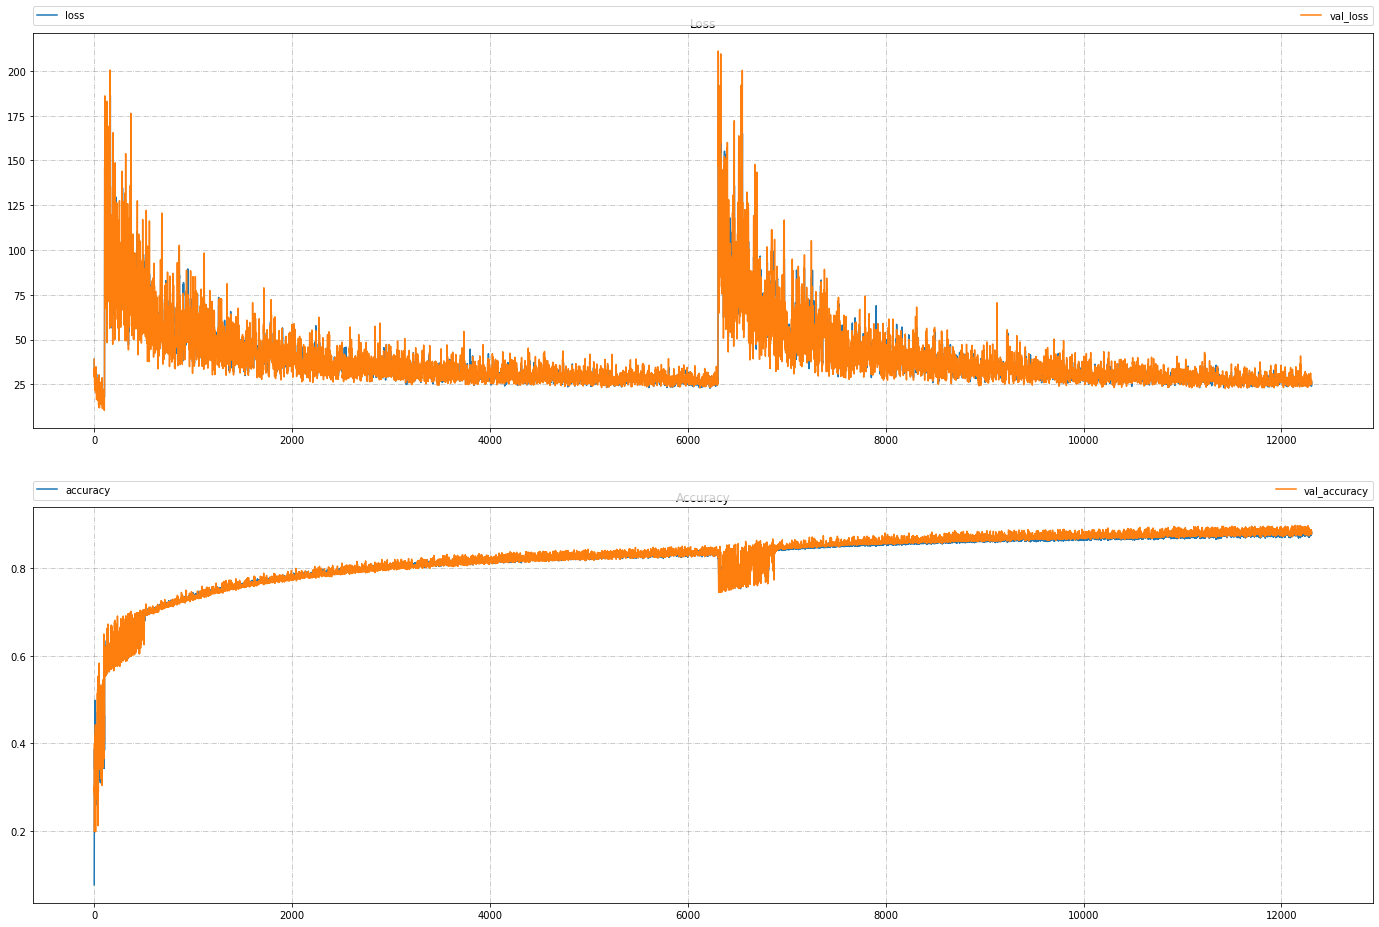

In [41]:
x = np.linspace(start=1, stop=history['epochs'], num=history['epochs'])

fig, (loss_chart, acc_chart) = plt.subplots(2)

fig.set_size_inches((24, 16))

loss_chart.set_title('Loss')
loss_chart.plot(x, history['loss'], label='loss')
loss_chart.plot(x, history['val_loss'], label='val_loss')
loss_chart.grid(b=True, color='gray', alpha=0.5, linestyle='dashdot')
loss_chart.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.0)

acc_chart.set_title('Accuracy')
acc_chart.plot(x, history['accuracy'], label='accuracy')
acc_chart.plot(x, history['val_accuracy'], label='val_accuracy')
acc_chart.grid(b=True, color='gray', alpha=0.5, linestyle='dashdot')
acc_chart.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.0)

plt.show()